### Search using facebook FAISS
[faiss](https://github.com/facebookresearch/faiss)

In [1]:
import json
# Used to import data from S3.
import pandas as pd

# Used to create the dense document vectors.
import torch
from sentence_transformers import SentenceTransformer

# Used to create and store the Faiss index.
import faiss
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Used to do vector searches and display the results.
#from vector_engine.utils import vector_search, id2details

### Import
Import the file exported from the excel file

In [243]:
defFile = "primitiveDef.json"

with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/in/' + str(defFile)) as json_file:
    defWord = json.load(json_file)

#print(defWord)

# Preprocessing
Follow guide from: https://www.pinecone.io/learn/faiss-tutorial/

In [245]:
# remove duplicates
defSing = [word for word in list(set(defWord)) if type(word) is str]

In [246]:
from sentence_transformers import SentenceTransformer
# initialize sentence transformer model
#model = SentenceTransformer('bert-base-nli-mean-tokens') #this is outdated: https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens
# info: https://www.sbert.net/docs/pretrained_models.html
model = SentenceTransformer('all-mpnet-base-v2')
# create sentence embeddings
sentence_embeddings = model.encode(defSing)
sentence_embeddings.shape
#print(sentence_embeddings)

(144, 768)

In [5]:
import faiss

d = sentence_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.is_trained
index.add(sentence_embeddings)
index.ntotal
print(len(sentence_embeddings[0]))

768


Here he use the clustering provided in the [faiss-wiki](https://github.com/facebookresearch/faiss/wiki/Faiss-building-blocks:-clustering,-PCA,-quantization)

In [6]:
# We decompose with sklearn PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(sentence_embeddings)

x = principalComponents[:,0].tolist()
y = principalComponents[:,1].tolist()
principalComponents = np.ascontiguousarray(principalComponents)

# We decompose with faiss PCA
mat = faiss.PCAMatrix(768, 2)
mat.train(sentence_embeddings)
assert mat.is_trained
tr = mat.apply_py(sentence_embeddings)
xf = tr[:,0].tolist()
yf = tr[:,1].tolist()

Here we apply Kmeans clustering from faiss

In [8]:
# dataset = tr
# dataset = principalComponents
dataset = sentence_embeddings

d = dataset.shape[1]
index = faiss.IndexFlatL2(d)
index.is_trained
index.add(dataset)
index.ntotal
ncentroids = 35
niter = 20
verbose = True
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
kmeans.train(dataset)
print(len(kmeans.centroids))

35


In [9]:
D, I = kmeans.index.search(dataset, 1)
#print(D)
#print(I[:,0])
Ilist = I[:,0].tolist()
Dlist = D[:,0].tolist()
#print(Ilist)
d = {'primitive':defSing, 'cluster':Ilist, 'distance':Dlist, 'x': xf, 'y': yf}
#print(d)

cluster = pd.DataFrame(d)
#print(cluster.head())


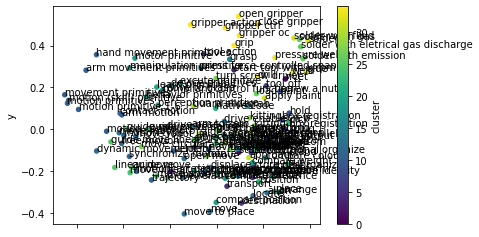

In [32]:
# Create scatter upon cluster type
ax1 = cluster.plot.scatter(x='x', y='y', c='cluster', colormap='viridis')    

for idx, row in cluster.iterrows(): 
    plt.text(row['x'], row['y'], row['primitive'])

# Try the tree approach branches
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# We can apply the links directly on the figure:
#https://stackoverflow.com/questions/40871268/how-to-add-hyperlink-to-pdf-using-matplotlib


In [ ]:
byCluster = cluster.groupby('cluster')

print(len(byCluster))

for clusterNr in range(len(byCluster)):
  #print(clusterGroup)

  displayCluster = byCluster.get_group(clusterNr)

  #print(displayCluster)

  ax1 = displayCluster.plot.scatter(x='x', y='y')

  # Plot name for each datapoint
  for idx, row in displayCluster.iterrows(): 
    plt.text(row['x'], row['y'], row['primitive'])

  #plt.savefig("D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/out/" + str(clusterNr) + ".png")
    

Here we apply agglomerative clustering from scipy following this [guide](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py)

In [247]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(dataset)


Text(0.5, 0, 'Number of points in node (or index of point if no parenthesis).')

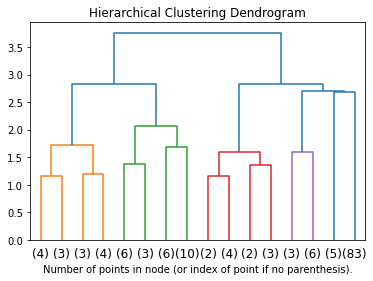

In [248]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")

We now follow the guide of topic modelling, [guide](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)

In [249]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=10, 
                            n_components=10, 
                            metric='cosine').fit_transform(sentence_embeddings)

In [250]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=2,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

16


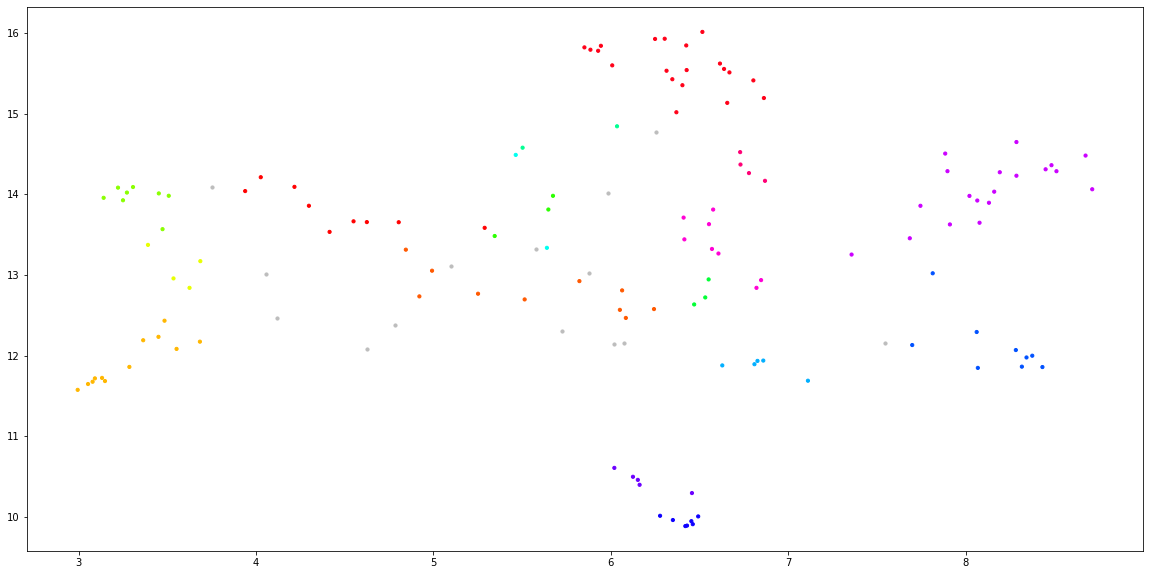

In [251]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(sentence_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

#print(result)

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
print(max(result.labels))
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='hsv_r')
#plt.colorbar()

In [252]:
d = {'primitive':defSing, 'cluster':result['labels'], 'x': result['x'], 'y': result['y']}

clusterDF = pd.DataFrame(d)
clusterDF['Doc_ID'] = range(len(clusterDF))

primitivesPerTopic = clusterDF.groupby(['cluster'], as_index = False).agg({'primitive': ' '.join})

print(primitivesPerTopic.primitive.values)

['convery put retreat excute insert bond plug drive pose learn set output before manipulation screw press force-controlled snap ff planer'
 'motor arm motion contact motion movement s velocity motion type behavior s compliant control function learn s arm movement s arm to zero motion  1-6 motion s hand movement s trajectory motion motion control motion (skill) device s free motion'
 'sync synchronize motion sequential or parallel synchronization point'
 'kitting box registration code object train object registration native code capture point cloud approach boxbottom kittingbox registration'
 'move guide move circular move to place navigate to loc guide move move to record position move circular move  lin move  ptp open move linear move move absolute move relative edge transition guide move spline move linear guide move linear dynamic movemement cartesian track'
 'detect distance perception detect color base detection check input'
 'compare presence compare orientation compare form comp

In [253]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(primitivesPerTopic.primitive.values, m=len(clusterDF))

In [267]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.cluster)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    print(top_n_words)
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['cluster'])
                     .primitive
                     .count()
                     .reset_index()
                     .rename({"cluster": "Topic", "primitive": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, primitivesPerTopic, n=1)
topic_sizes = extract_topic_sizes(clusterDF); topic_sizes.head(10)
top_n_words[0]

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
{-1: [('force', 0.2615691210303158)], 0: [('motion', 0.7743565761044385)], 1: [('sequential', 0.7099733285108573)], 2: [('registration', 0.6831531195719809)], 3: [('guide', 0.5513106059163246)], 4: [('detect', 0.9503702486702345)], 5: [('compare', 1.5119515752603436)], 6: [('spin', 0.8553332238032111)], 7: [('store', 1.290400336969297)], 8: [('approach', 2.580800673938594)], 9: [('slide', 2.8511107460107032)], 10: [('locate', 2.1383330595080277)], 11: [('drive', 1.9356005054539456)], 12: [('gripper', 1.200134066836393)], 13: [('tool', 0.8602668913128646)], 14: [('solder', 0.8000893778909286)], 15: [('fee', 0.5522014777306667)], 16: [('grasp', 0.9503702486702345)]}


[('motion', 0.7743565761044385)]

In [256]:
topWords = pd.DataFrame.from_dict(top_n_words, orient='index')
topWords['labels'] = topWords.index
#print(topWords)
print("The merged DataFrame")
resultTopWords = pd.merge(result, topWords, on = 'labels', how = "inner")
resultTopWords = resultTopWords.rename(columns={0:"recurringWord"})
print(resultTopWords)

The merged DataFrame
            x          y  labels                  recurringWord
0    3.222184  14.083298      12   (gripper, 1.200134066836393)
1    3.141239  13.957131      12   (gripper, 1.200134066836393)
2    3.452214  14.011641      12   (gripper, 1.200134066836393)
3    3.508312  13.982469      12   (gripper, 1.200134066836393)
4    3.250354  13.926473      12   (gripper, 1.200134066836393)
..        ...        ...     ...                            ...
139  3.535034  12.957276      13     (tool, 0.8602668913128646)
140  5.639951  13.336808       8  (approach, 2.580800673938594)
141  5.464258  14.489373       8  (approach, 2.580800673938594)
142  6.035308  14.844246       9    (slide, 2.8511107460107032)
143  5.503006  14.578833       9    (slide, 2.8511107460107032)

[144 rows x 4 columns]


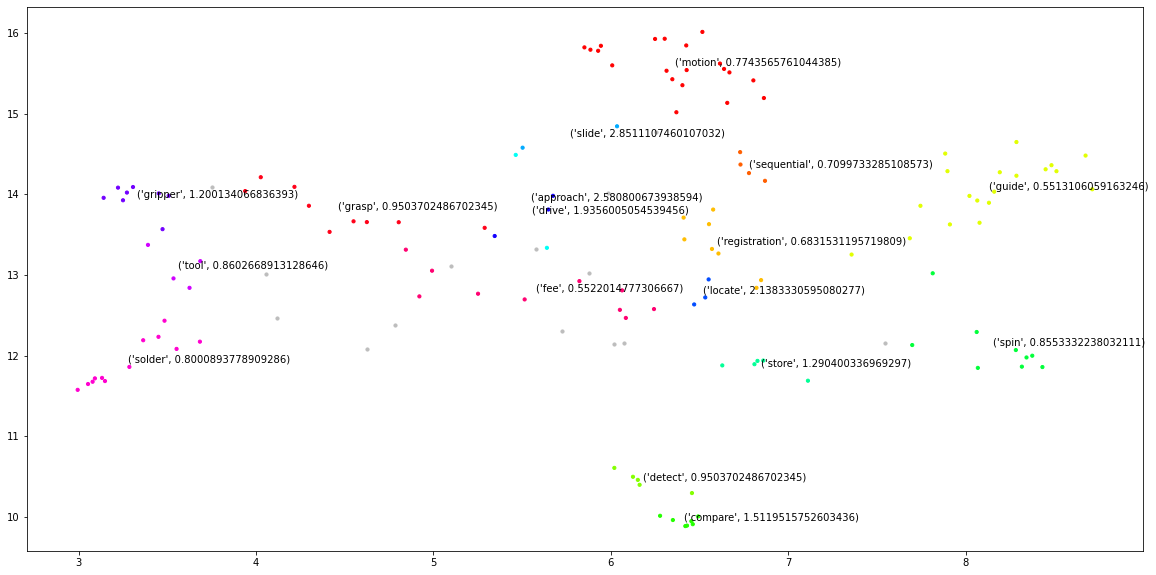

In [257]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = resultTopWords.loc[resultTopWords.labels == -1, :]
clustered = resultTopWords.loc[resultTopWords.labels != -1, :]
#print(clustered.keys())
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='hsv')
#plt.colorbar()

#loop through labels and plot each cluster

# group by "X" column
groups = clustered.groupby('labels')
  
# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    x = groups.get_group(i)['x'].mean()
    y = groups.get_group(i)['y'].mean()
    
    plt.annotate(groups.get_group(i).iloc[0]["recurringWord"], xy=(x,y))

    #add label
    # plt.annotate(topic["recurringWord"], topic['x','y'].mean(),
    #              horizontalalignment='center',
    #              verticalalignment='center',
    #              size=20, weight='bold',
    #              color=clustered.labels) 